# IEEE-CIS Fraud Detection

## Integrating machine learning to detect fraud

Industries and individuals are suffering from fraudulent damages. Implementing effective and accurate fraud prevention systems can save businesses and consumers millions of dollars. With the goal of improving customer experience, [IEEE Computational Intelligence Society](https://cis.ieee.org/) has partnered with payment service company, [Vesta Corporation](https://trustvesta.com/), to find more effective solutions for fraud prevention. 

In this project, we will be participating in this competition and using Kaggle's competition [IEEE-CIS Fraud Detection](https://www.kaggle.com/c/ieee-fraud-detection) machine dataset. The purpose of the competition is to use historical Vesta's real-world e-commerce transaction to predict whether a transaction is fraud or not. We will employ supervised classification models for this task. 
 * __Supervised__: The goal is to train a model to learn from features to predict the probability of an online fraudulent transaction given labels in the _isFraud_ column. 
 * __Classification__: The label is a binary variable: 0 (not fraud), 1 (fraud)
 
### Overview of Data
This dataset contains two files, _identity_ and _transaction_, which are joined by _TransactionID_. Not all transactions have corresponding identity information.

__Categorical Features - Transaction__
 * ProductCD
 * card1 - card6
 * addr1, addr2
 * P_emaildomain
 * R_emaildomain
 * M1 - M9
 
__Categorical Features - Identity__
 * DeviceType
 * DeviceInfo
 * id_12 - id_38
 
The _TransactionDT_ feature is a timedelta from a given reference datetime (not an actual timestamp).

In this notebook, we will be using mainly the transaction files to train and test our model. 

## Metric ROC AUC

Before we begin, let's get an understanding of how each submission is evaluated. For this competition, models are being judged by the Receiver Operating Characteristic Area Under the Curve (ROC AUC), which measures the true positive rate versus the false positive rate. 

ROC AUC measures the probability between 0 and 1. While a score of 0.5 indicates random guessing, better models will receive a higher score. Setting accuracy as the metric isn't recommend since real-world datasets have imbalanced classes. The model will likely be good in predicting the dominant class and misclassify the minority class. In this project, we can anticipate that most transactions are not fraud. If we were to measure based on accuracy, our model would preform well in detecting non-fraud related transactions. That wouldn't be the most effective way in preventing fraud if our model is not good at identifying it. Thus, ROC AUC is used to reflect the accuracy of a classifier.

## Read in Data

There are a total of 5 files: 
 * 1 example submission files 
 * 2 transaction files (test and train)
 * 2 identity files (test and train) 

Since the transaction files include our target variable _isFraud_ column, we will predominately be exploring transaction files. 

In [25]:
# Numpy and pandas
import pandas as pd
import numpy as np

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Statistics tools
import scipy.stats as stats

# Model prep and Modeling 
from sklearn.decomposition import PCA 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV

# Decision Trees
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from IPython.display import Image
import pydotplus
import graphviz

# Random Forests 
from sklearn import ensemble

# SVM
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVR
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

# Evaluate
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse

# Import data
from sqlalchemy import create_engine
import warnings

In [2]:
# List files available
test_iden = pd.read_csv('/Users/tsawaengsri/Desktop/Data Science Courses/Datasets/ieee-fraud-detection/test_identity.csv')
test_trans = pd.read_csv('/Users/tsawaengsri/Desktop/Data Science Courses/Datasets/ieee-fraud-detection/test_transaction.csv')
train_iden = pd.read_csv('/Users/tsawaengsri/Desktop/Data Science Courses/Datasets/ieee-fraud-detection/train_identity.csv')
train_trans = pd.read_csv('/Users/tsawaengsri/Desktop/Data Science Courses/Datasets/ieee-fraud-detection/train_transaction.csv')


In [12]:
# Format column headings 

test_iden.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('__', '_').str.replace('(', '').str.replace(')', '')
test_trans.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('__', '_').str.replace('(', '').str.replace(')', '')
train_iden.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('__', '_').str.replace('(', '').str.replace(')', '')
train_trans.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('__', '_').str.replace('(', '').str.replace(')', '')

Index(['transactionid', 'isfraud', 'transactiondt', 'transactionamt',
       'productcd', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'v330', 'v331', 'v332', 'v333', 'v334', 'v335', 'v336', 'v337', 'v338',
       'v339'],
      dtype='object', length=394)

In [14]:
# Training data

print('Training transaction data shape: ', train_trans.shape)
train_trans.head()

Training transaction data shape:  (590540, 394)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The training data has 590,540 observations (each one a separate online transaction) and 394 attributes including the target variable we want to predict.

In [16]:
print('Testing transaction data shape: ', test_trans.shape)
test_trans.head()

Testing transaction data shape:  (506691, 393)


,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The testing data contains 506,691 observations and 393 attributes. This dataset is smaller than the training set and does not contain the target variable. 

## Exploratory Data Analysis 
Exploratory Data Analysis (EDA) is an iterative process to explore the data and summarize characteristics by calculating statistics or visualize methods. The purpose of EDA is gain an understanding of the data by identifying trends, anomalies, or relationships that might be helpful when making decisions in the modeling process. 

### Univariate Analysis

We will begin EDA by exploring individual variables, particularly our target variable, _isFraud_. The target is what we are asked to predict: either a 0 for non-fraud transactions, or a 1 for fraud transaction. First, let's examine the number of transactions falling into each category.

In [21]:
train_trans['isFraud'].value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

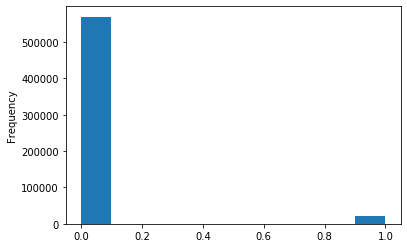

In [22]:
train_trans['isFraud'].astype(int).plot.hist()

We can see an imbalanced class problem from the value count and histogram. Majority of transactions were non-fraudlent transactions. Once we get into more sophisticated machine learning models, we can weight the classes by their representation in the data to reflect this imbalance.

### Missing Values
Now, we will take a look at missing values in each column.

In [23]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [24]:
missing_values_table(train_trans)

Your selected dataframe has 394 columns.
There are 374 columns that have missing values.


,Missing Values,% of Total Values
dist2,552913,93.6
D7,551623,93.4
D13,528588,89.5
D14,528353,89.5
D12,525823,89.0
D6,517353,87.6
D9,515614,87.3
D8,515614,87.3
V157,508595,86.1
V163,508595,86.1


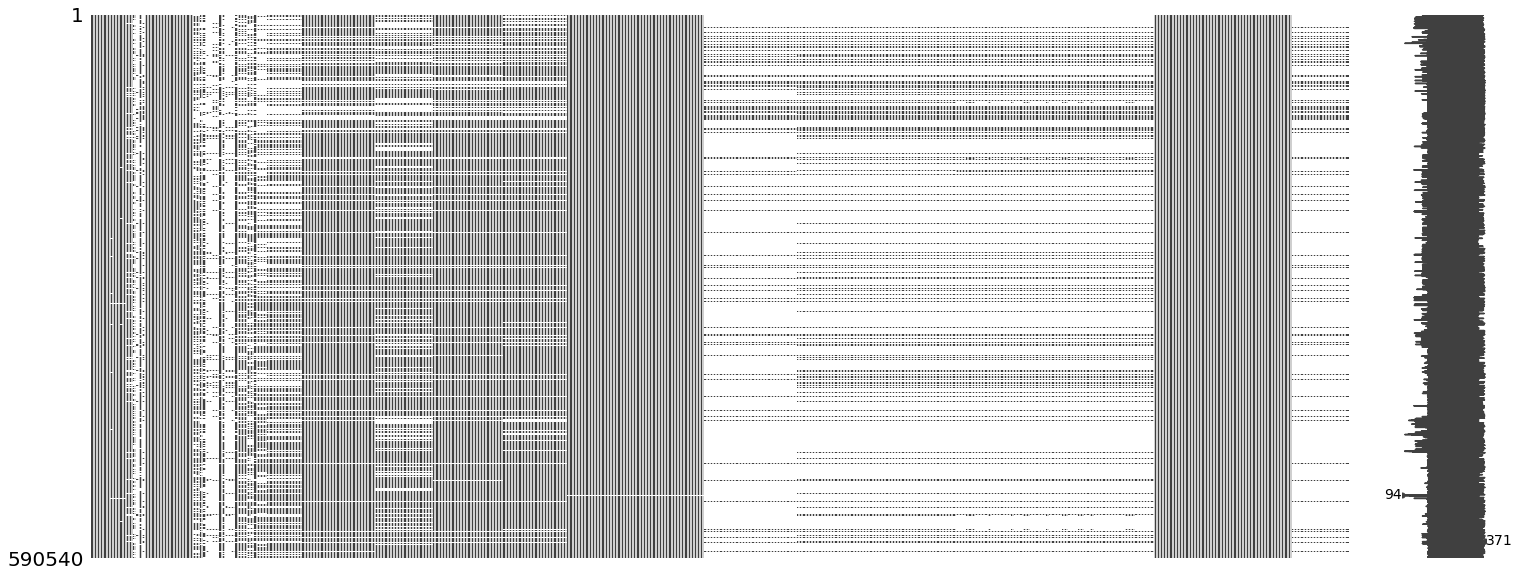

In [26]:
msno.matrix(train_trans)

We can observe that there are missing values in majority of the columns. There appears to be a pattern of missing values in columns V122-V163. Due to  the limited information given on these columns for privacy issues, it is difficult to determine if these columns offer helpful information for predicting fraud.